In [10]:
import pandas as pd


df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)  

In [15]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
  def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
    self.scoring = scoring
    self.estimator = clone(estimator)
    self.k_features = k_features
    self.test_size = test_size
    self.random_state = random_state
  def fit(self, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,random_state=self.random_state)
    dim = X_train.shape[1]
    self.indices_ = tuple(range(dim))
    self.subsets_ = [self.indices_]
    score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
    self.scores_ = [score]
    while dim > self.k_features:
      scores = []
      subsets = []
      for p in combinations(self.indices_, r=dim - 1):
        score = self._calc_score(X_train, y_train, X_test, y_test, p)
        scores.append(score)
        subsets.append(p)
      best = np.argmax(scores)
      self.indices_ = subsets[best]
      self.subsets_.append(self.indices_)
      dim -= 1
      self.scores_.append(scores[best])
    self.k_score_ = self.scores_[-1]
    return self
  def _calc_score(self, X_train, y_train, X_test, y_test, indices):
    self.estimator.fit(X_train[:, indices], y_train)
    y_pred = self.estimator.predict(X_test[:, indices])
    score = self.scoring(y_test, y_pred)
    return score
      



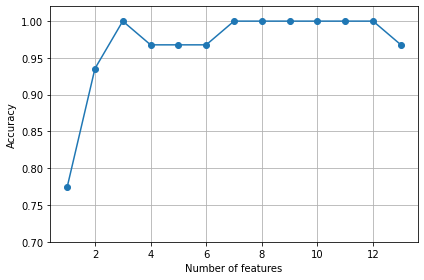

In [16]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

# Random forest

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)
feat_labels = df_wine.columns[1:]
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279
